In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
df = pd.read_csv("mode_of_transportation.csv", sep=';', encoding='ISO-8859-1', dtype=str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202203 entries, 0 to 202202
Data columns (total 24 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ï»¿ind_id       202203 non-null  object
 1   ind_definition  202202 non-null  object
 2   reportyear      202202 non-null  object
 3   race_eth_code   202202 non-null  object
 4   race_eth_name   202202 non-null  object
 5   geotype         202202 non-null  object
 6   geotypevalue    202202 non-null  object
 7   geoname         202202 non-null  object
 8   county_name     200298 non-null  object
 9   county_fips     200298 non-null  object
 10  region_name     89264 non-null   object
 11  region_code     89264 non-null   object
 12  mode            202202 non-null  object
 13  mode_name       202202 non-null  object
 14  pop_total       161357 non-null  object
 15  pop_mode        161357 non-null  object
 16  percent         161231 non-null  object
 17  LL95CI_percent  89215 non-nul

In [4]:
cols = ['reportyear', 'mode_name', 'pop_total', 'percent']
df = df[cols]

In [5]:
df['pop_total'] = df['pop_total'].astype(str).str.replace('.', '', regex=False)
df['percent'] = df['percent'].astype(str).str.replace('.', '', regex=False)

# Ubah ke numerik, jika ada yang gagal konversi, ganti jadi NaN
df['pop_total'] = pd.to_numeric(df['pop_total'], errors='coerce')
df['percent'] = pd.to_numeric(df['percent'], errors='coerce')

# Cek lagi tipe data
print(df.dtypes)

# Lanjutkan imputasi dengan median/mode
df['percent'] = df['percent'].fillna(df['percent'].median())
df['pop_total'] = df['pop_total'].fillna(df['pop_total'].median())
df['mode_name'] = df['mode_name'].fillna(df['mode_name'].mode()[0])
df['reportyear'] = df['reportyear'].fillna(df['reportyear'].mode()[0])

# Cek hasilnya
print("Missing values sesudah imputation:")
print(df.isnull().sum())

reportyear     object
mode_name      object
pop_total     float64
percent       float64
dtype: object
Missing values sesudah imputation:
reportyear    0
mode_name     0
pop_total     0
percent       0
dtype: int64


In [6]:
import numpy as np

# --- Handling Outliers dengan metode IQR ---
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Tampilkan batas bawah & atas (biar bisa dicek)
    print(f"\n{column}:")
    print(f"  Q1 = {Q1:.2f}, Q3 = {Q3:.2f}, IQR = {IQR:.2f}")
    print(f"  Lower Bound = {lower_bound:.2f}, Upper Bound = {upper_bound:.2f}")
    
    # Tandai outlier
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"  Jumlah outlier di '{column}': {len(outliers)}")
    
    # Ganti nilai outlier jadi batas bawah/atas (Winsorization)
    df[column] = np.where(df[column] < lower_bound, lower_bound,
                 np.where(df[column] > upper_bound, upper_bound, df[column]))
    
    return df

# Terapkan ke kolom numerik
df = remove_outliers_iqr(df, 'pop_total')
df = remove_outliers_iqr(df, 'percent')


pop_total:
  Q1 = 1380.00, Q3 = 2556.00, IQR = 1176.00
  Lower Bound = -384.00, Upper Bound = 4320.00
  Jumlah outlier di 'pop_total': 23849

percent:
  Q1 = 702.00, Q3 = 2137673414.00, IQR = 2137672712.00
  Lower Bound = -3206508366.00, Upper Bound = 5344182482.00
  Jumlah outlier di 'percent': 35209


In [7]:
from scipy.stats import f_oneway

# Hapus NaN
anova_df = df.dropna(subset=['mode_name', 'percent'])
groups = [group['percent'].values for name, group in anova_df.groupby('mode_name')]

# ANOVA
anova_stat, anova_p = f_oneway(*groups)
print("=== ANOVA Test ===")
print(f"F-statistic : {anova_stat:.4f}")
print(f"p-value      : {anova_p:.6f}")

if anova_p < 0.05:
    print("Kesimpulan : Terdapat perbedaan signifikan antar mode_name (p < 0.05)")
else:
    print("Kesimpulan : Tidak terdapat perbedaan signifikan antar mode_name (p >= 0.05)")

# Hitung Effect Size (eta squared manual)
ss_between = sum(len(g) * (g.mean() - anova_df['percent'].mean())**2 for g in groups)
ss_total = sum((anova_df['percent'] - anova_df['percent'].mean())**2)
eta_squared = ss_between / ss_total

print(f"\nEffect Size (Eta Squared) = {eta_squared:.4f}")
if eta_squared < 0.01:
    print("Interpretasi: Pengaruh kecil")
elif eta_squared < 0.06:
    print("Interpretasi: Pengaruh sedang")
elif eta_squared < 0.14:
    print("Interpretasi: Pengaruh cukup besar")
else:
    print("Interpretasi: Pengaruh besar")

=== ANOVA Test ===
F-statistic : 12867.8930
p-value      : 0.000000
Kesimpulan : Terdapat perbedaan signifikan antar mode_name (p < 0.05)

Effect Size (Eta Squared) = 0.2763
Interpretasi: Pengaruh besar


In [8]:
from scipy.stats import kruskal

# --- Kruskal-Wallis Test ---
kruskal_stat, kruskal_p = kruskal(*groups)

print("\n=== Kruskal–Wallis Test ===")
print(f"H-statistic : {kruskal_stat:.4f}")
print(f"p-value     : {kruskal_p:.6f}")

# Interpretasi hasil
if kruskal_p < 0.05:
    print("Kesimpulan : Ada perbedaan signifikan antar mode_name (p < 0.05)")
else:
    print("Kesimpulan : Tidak ada perbedaan signifikan antar mode_name (p >= 0.05)")


=== Kruskal–Wallis Test ===
H-statistic : 43594.2026
p-value     : 0.000000
Kesimpulan : Ada perbedaan signifikan antar mode_name (p < 0.05)


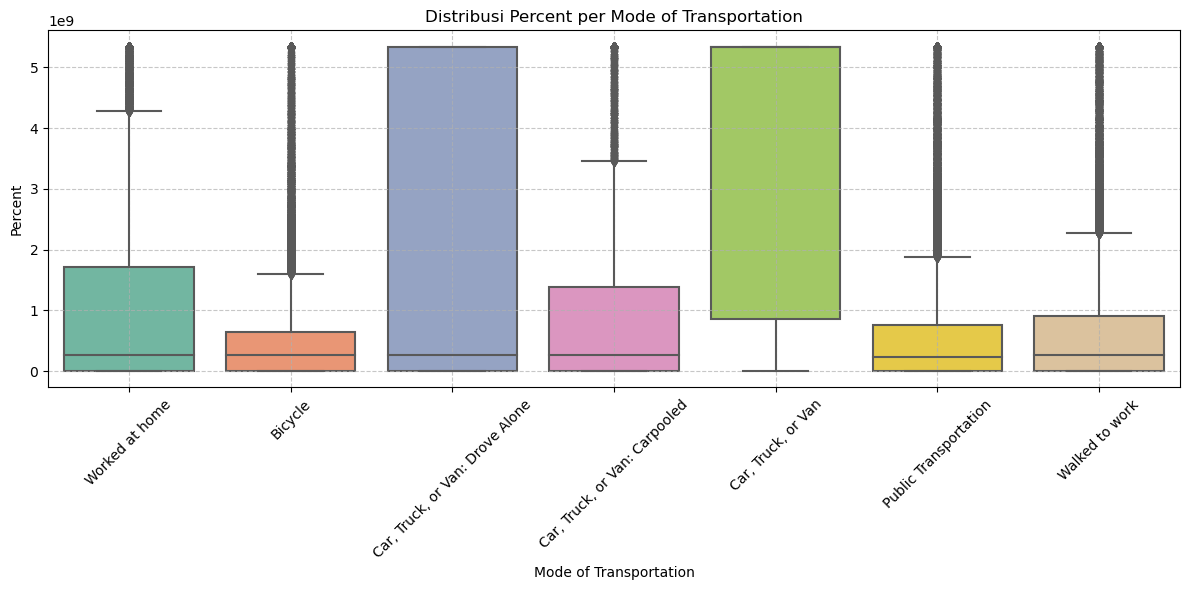

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Atur ukuran figure
plt.figure(figsize=(12, 6))

# Buat boxplot untuk melihat distribusi 'percent' per mode_name
sns.boxplot(data=df, x='mode_name', y='percent', palette='Set2')

plt.title('Distribusi Percent per Mode of Transportation')
plt.xlabel('Mode of Transportation')
plt.ylabel('Percent')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

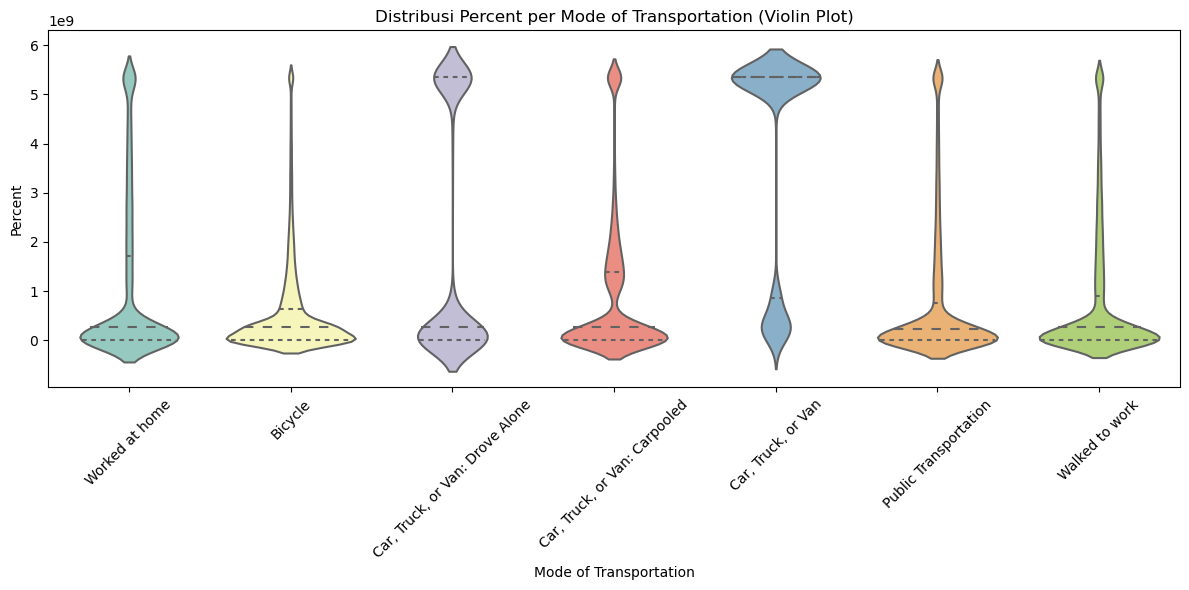

In [10]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='mode_name', y='percent', palette='Set3', inner='quart')
plt.title('Distribusi Percent per Mode of Transportation (Violin Plot)')
plt.xlabel('Mode of Transportation')
plt.ylabel('Percent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_23424\1618104939.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='mode_name', y='percent', estimator='mean', ci=None, palette='coolwarm')


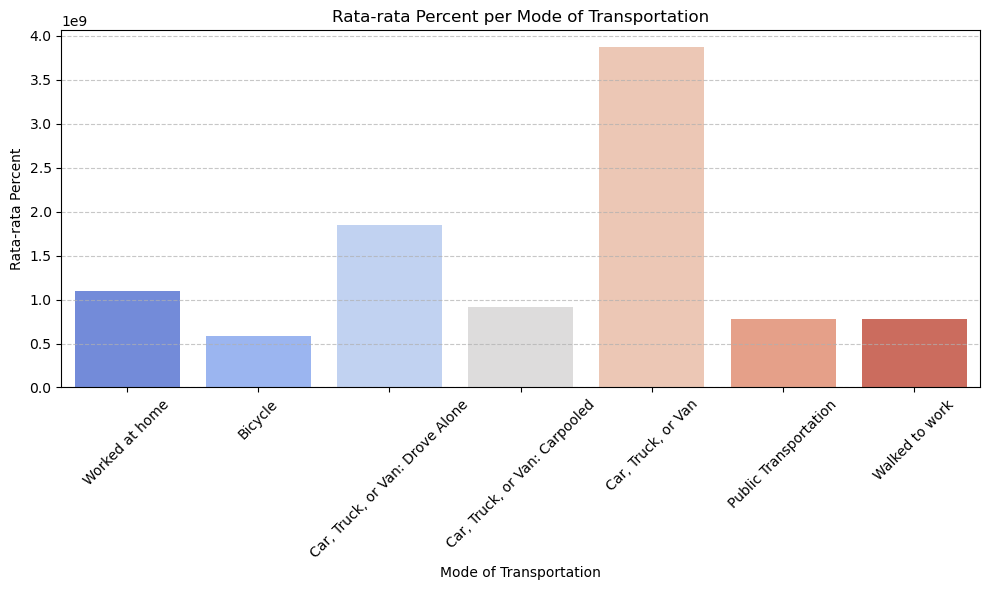

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='mode_name', y='percent', estimator='mean', ci=None, palette='coolwarm')
plt.title('Rata-rata Percent per Mode of Transportation')
plt.xlabel('Mode of Transportation')
plt.ylabel('Rata-rata Percent')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()